In [1]:
import numpy as np
import pandas as pd
import openpyxl
from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings("ignore")


## Analisis para el dataframe

In [2]:
Alameda_pred = pd.read_excel('predicciones_cabello_alameda.xlsx')
df_temp=pd.read_excel('maximos_minimos.xlsx')
#contiene el resultado de aplicar el logaritmo natural (base e) a los valores de la columna "Alameda_predicho"
#Alameda_pred["Alameda_predicho_log"] = Alameda_pred["Alameda_predicho"].apply(np.log)
#Esta columna contiene las diferencias entre los valores adyacentes de la columna 
#Alameda_pred["Alameda_predicho_log_diff"] = Alameda_pred["Alameda_predicho_log"].diff() #es útil para calcular cambios porcentuales o diferencias entre valores en series de tiempo
Alameda_pred.set_index("Time", inplace = True)
Alameda_pred = Alameda_pred.drop('Cabello_predicho', axis=1)
Alameda_pred

,Alameda_predicho
Time,
2017-03-21,862.012475
2017-03-22,799.513999
2017-03-23,831.313165
2017-03-24,800.960075
2017-03-25,594.288990
...,...
2024-04-03,885.500379
2024-04-04,989.551327
2024-04-05,1019.467525


In [3]:
Alameda_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2575 entries, 2017-03-21 to 2024-04-07
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Alameda_predicho  2575 non-null   float64
dtypes: float64(1)
memory usage: 40.2 KB


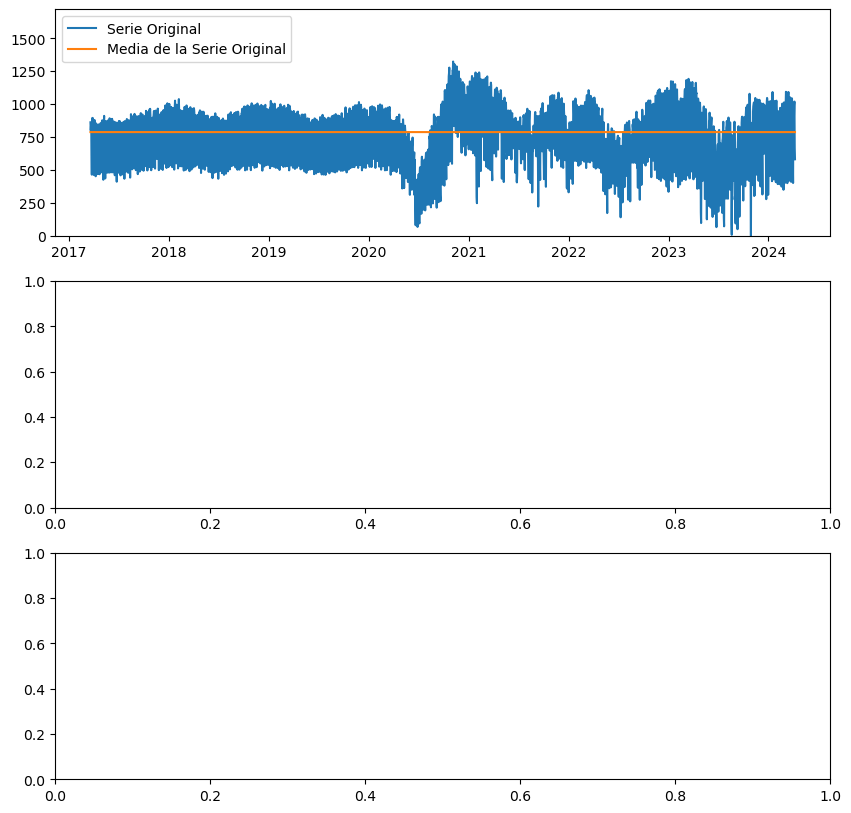

In [4]:
# Separar x y y para el gráfico
x = Alameda_pred.index

y = Alameda_pred["Alameda_predicho"]
y_media = [np.mean(y) for _ in y]

y_log = Alameda_pred["Alameda_predicho"]
y_log_media = [np.mean(y_log) for _ in y_log]

y_log_diff = Alameda_pred["Alameda_predicho"]
y_log_diff_mean = [np.mean(y_log_diff) for _ in y_log_diff]

# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (10, 10))
ax1, ax2, ax3 = fig.subplots(3, 1)

ax1.plot(x, y, label = "Serie Original")
ax1.plot(x, y_media, label = "Media de la Serie Original")
ax1.set_ylim(0, np.max(y)*1.3)
ax1.legend(loc = "upper left")



## Comprobación de la estacionaridad de la serie con la prueba del Dickey-Fuller aumentada

In [5]:

for serie, nombre_serie in zip([y, y_log, y_log_diff], ["Serie Original", "Serie Log.", "Serie. Log. Diff"]):
    
    print("------------------------------------------------------------------")
    
    print("Estamos trabajando con la serie {}\n".format(nombre_serie))
    resultado_analisis = adfuller(serie) 
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
    print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))

------------------------------------------------------------------
Estamos trabajando con la serie Serie Original

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -3.535403542785059

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.007123069660445296

------------------------------------------------------------------
Estamos trabajando con la serie Serie Log.

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -3.535403542785059

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.007123069660445296

------------------------------------------------------------------
Estamos trabajando con la serie Serie. Log. Diff

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -3.535403542785059

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.007123069660445296



En cada caso, el valor estadístico de ADF es menor que el valor crítico (-2.89), lo que indica que podemos rechazar la hipótesis nula de que la serie no es estacionaria. 

Además, los p-valores son menores que el nivel de significación (0.05), lo que también sugiere que podemos rechazar la hipótesis nula.

CONCLUSION: Según la Prueba del Dickey-Fuller Aumentada, todas las series (Serie Original, Serie Log y Serie Log Diff) son estacionarias. Esto significa que no hay una tendencia clara o patrón sistemático que cambie con el tiempo en estas series de tiempo.

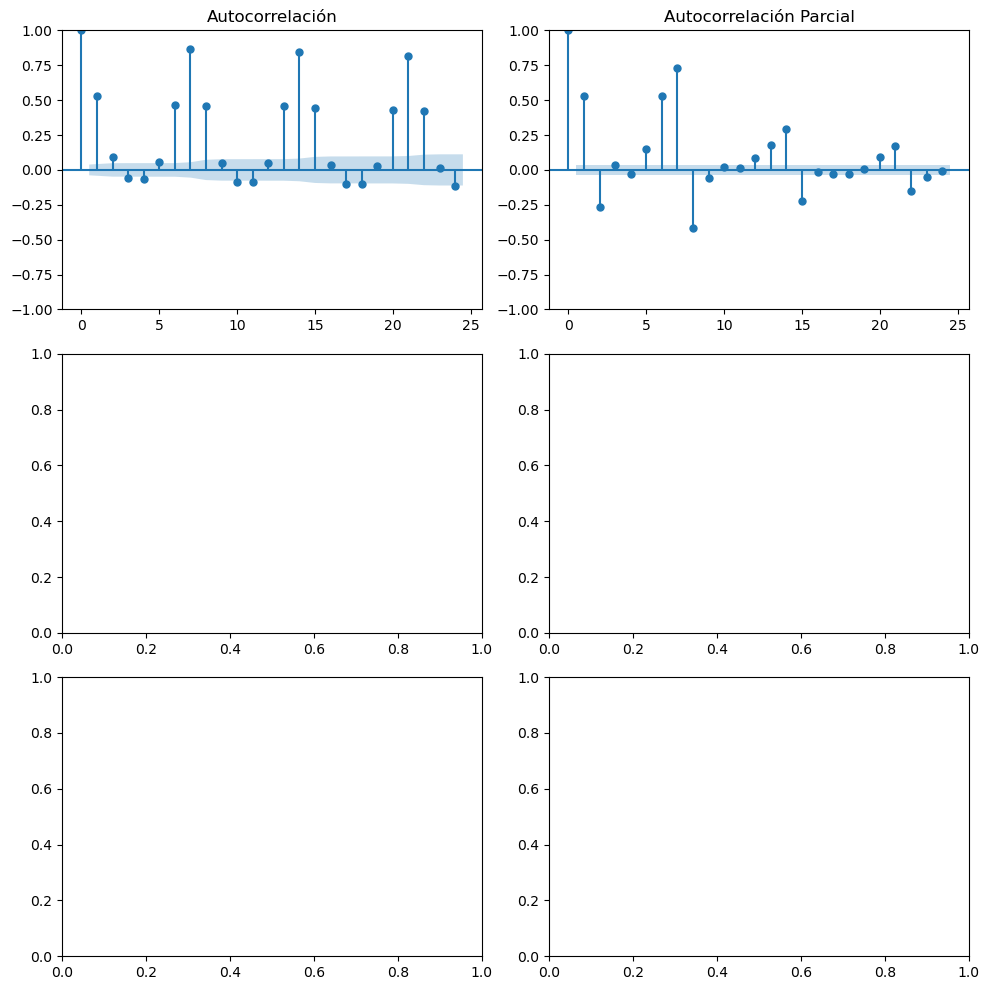

In [6]:
LAGS = 24

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")



fig.tight_layout()

## Separación Train y Test

In [7]:
serie_a_predecir = y_log
y_index = serie_a_predecir.index

date_train = int(len(y_index)*0.9)

y_train = serie_a_predecir[y_index[:date_train]]
y_test = serie_a_predecir[y_index[date_train:len(y_index)]]

In [8]:
print(df_temp)

          Fecha  Temp. Máxima  Temp. Mínima
0    2017-03-21          30.6          11.8
1    2017-03-22          27.8          10.3
2    2017-03-23          27.2          10.7
3    2017-03-24          15.5          13.3
4    2017-03-25          26.4          11.8
...         ...           ...           ...
2549 2024-03-13          28.4          12.3
2550 2024-03-14          29.6          12.4
2551 2024-03-15          30.1          12.1
2552 2024-03-16          29.4          14.2
2553 2024-03-17          28.9          17.0

[2554 rows x 3 columns]


In [9]:
y_train.tail()

Time
2023-07-20    865.991190
2023-07-21    416.550134
2023-07-22    135.986193
2023-07-23     71.544089
2023-07-24    626.742424
Name: Alameda_predicho, dtype: float64

In [10]:
y_test.head()

Time
2023-07-25    678.439153
2023-07-26    759.655861
2023-07-27    795.924249
2023-07-28    708.527169
2023-07-29    557.894414
Name: Alameda_predicho, dtype: float64

## Gridsearch: la búsqueda de los parámetros óptimos para el modelo ARIMA

In [11]:
# Para hacer el gridsearch, vamos a calcular los posibles valores que vamos a pasarle al modelo.
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Los dejamos a cero para sólo analizar un modelo ARIMA.
seasonal_pdq = [(0, 0, 0, 0)]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


un modelo ARIMA se repsenta como ARIMA (p, d, q) donde:

AR (p): representa la parte "Autorregresiva" del modelo. La intuición básica consiste en que los valores pasados más próximos al momento "t", tendrán mayor impacto en los valores presentes. Para determinar el orden "p" del modelo, podemos utilizar el plot de autocorrelación parcial

I (d): representa la parte "Integral" del modelo y este parámetro del modelo nos dice cuantos diferenciaciones (restas de la serie contra si misma) se tienen que llevar a cabo para convertir la serie en estacionaria.

MA (q): representa la parte de "Medias Móviles". Como vimos, esto implica que el error del modelo se establece como una combinaciòn lineal de los errores observados en el pasado. Para determinar el orden "q" del modelo, podemos utilizar el plot de autocorrelación.

El modelo básico de ARIMA se puede extender más alla incorporando la estacionalidad de la serie y variables exógenas. En este caso estaríamos hablado del modelo SARIMAX representado por (p, d, q) x (P, D, Q) S: donde los parámetros (P, D, Q) representan la misma idea que los (p, d, q) pero tratan sobre la parte estacional de la serie.

El parámetro S a su vez representa el número de periodos que tienen que pasar para que la estacionalidad se repita: 12 para meses, 4 para trimestres etc.

In [12]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        # alguna combinación de parámetros en SARIMAX, no son válidos
        # y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros demora {} minutos!".format((et - st)/60))

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:37659.49605793132
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:34927.91016827767
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:33306.465458576495
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:31294.914321793156
ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:31276.72483285631
ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:30309.52448419266
ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:32957.60177279917
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:31278.489314858183
ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:31315.805446337225
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:31271.67416483898
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:31259.176250448432
ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:30342.97697751548
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:31294.409238038264
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:30555.609132885962
ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:30298.719029087424
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:32635.186656633443
ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:31425.557860929905
ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:31148.804335618428
ARIMA(2, 0, 0)x(0

In [13]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))

El mejor modelo es (2, 1, 2), 
Con un AIC de 29836.668945154423


En este caso, el modelo ARIMA seleccionado es (2, 1, 2), lo que significa que tiene:

p = 2: Dos términos autoregresivos.
d = 1: Un término de diferenciación para hacer que la serie sea estacionaria.
q = 2: Dos términos de media móvil.

El AIC (Criterio de Información de Akaike) es una medida de la calidad relativa de un modelo estadístico para un conjunto dado de datos. Cuanto menor sea el valor de AIC, mejor se ajusta el modelo a los datos. En este caso, el AIC reportado es 29836.66894494467, lo que sugiere que este modelo proporciona un buen ajuste a los datos.

## Entrenamos el modelo con los mejores parametros

In [14]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

In [15]:
#Interpretación del mejor modelo
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9527      0.016     59.546      0.000       0.921       0.984
ar.L2         -0.6352      0.017    -37.376      0.000      -0.668      -0.602
ma.L1         -2.0896      0.044    -47.342      0.000      -2.176      -2.003
ma.L2          1.0001      0.048     21.037      0.000       0.907       1.093
sigma2      1.284e+04   7.28e-06   1.76e+09      0.000    1.28e+04    1.28e+04


Coeficientes AR (Autoregresión): sugiere que hay una fuerte correlación positiva con el valor anterior y una correlación negativa con el segundo valor anterior. Es decir, los valores pasados influyen significativamente en el valor actual.

Coeficientes MA (Media móvil): Esto indica que los errores pasados tienen un impacto significativo en el valor actual, con una fuerte relación negativa con el error anterior y una relación positiva con el segundo error anterior.

Varianza del error (sigma2): la varianza del error es aproximadamente 12840, lo que sugiere que hay una cantidad significativa de variabilidad en los datos que no está siendo capturada por el modelo.

Estadísticos z y valores p: todos los valores de p son muy pequeños (cercanos a cero), lo que indica que todos los coeficientes son estadísticamente significativos.

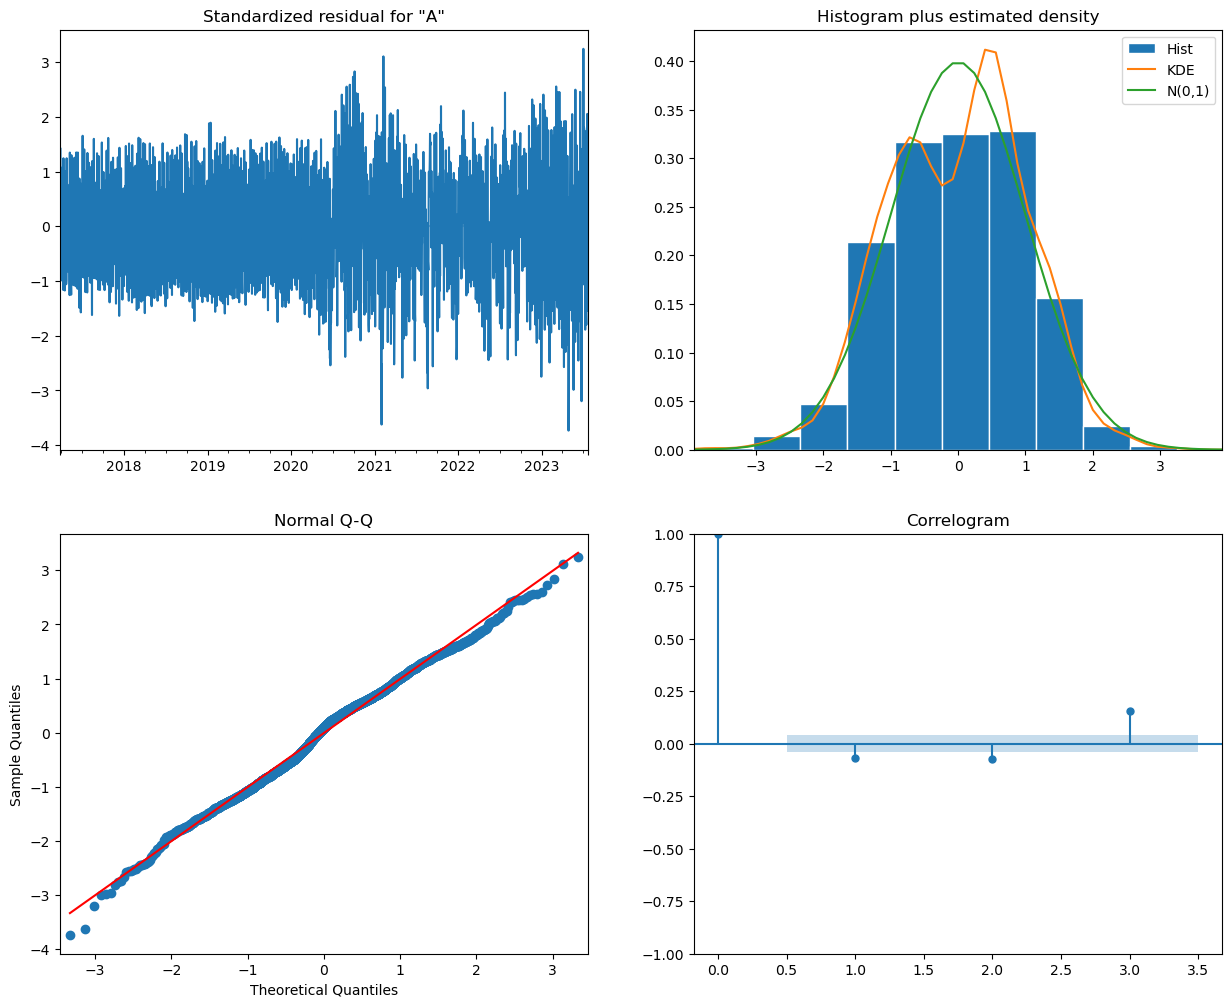

In [16]:
results.plot_diagnostics(figsize = (15, 12), lags = 3);

## Predicción utilizando el modelo

In [17]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

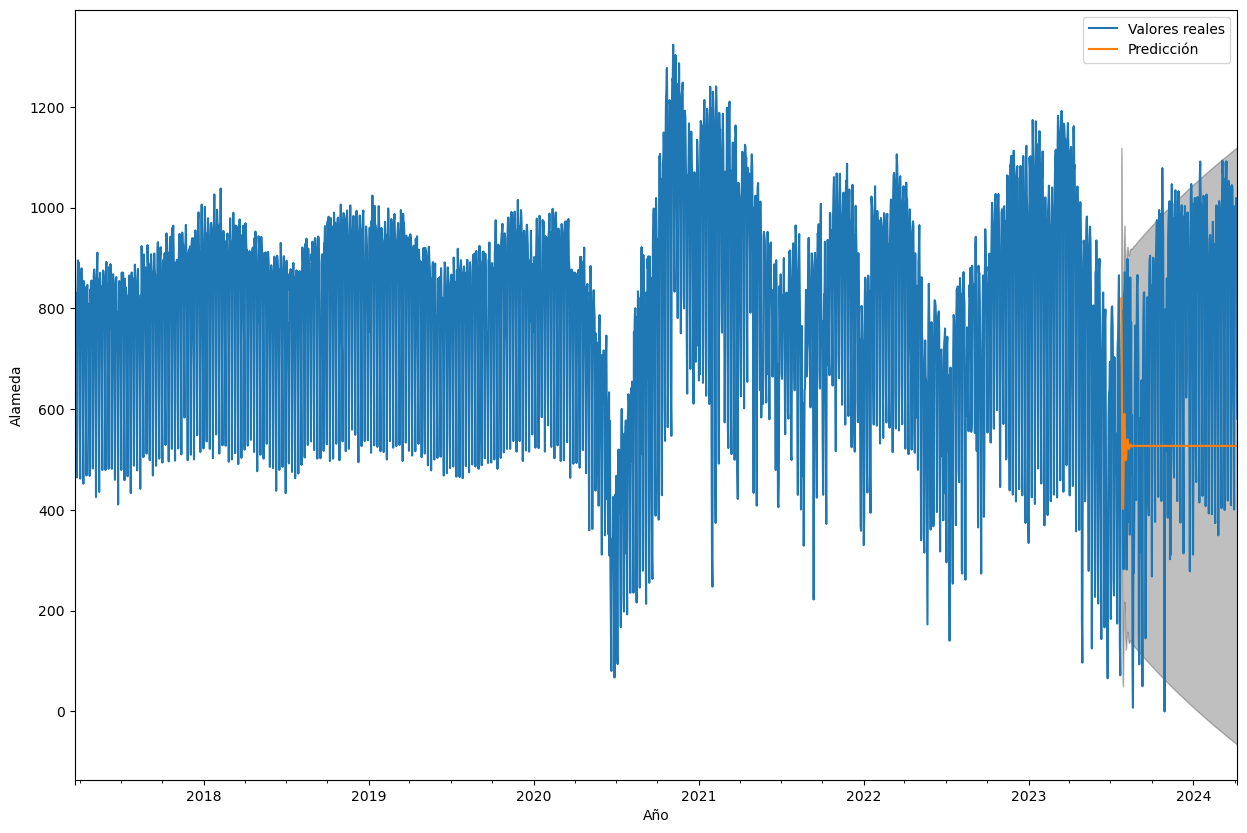

In [18]:
ax = serie_a_predecir.plot(label = 'Valores reales', figsize = (15, 10))

pred_uc.predicted_mean.plot(ax = ax, label = 'Predicción')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Año')
ax.set_ylabel('Alameda')

plt.legend()
plt.show()

In [22]:
y_pred = pred_ci.iloc[:, 0]

## Root Mean Square Error (MRSE)

In [23]:
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("El modelo ARIMA con los parametros {}, ha dado un rmse en test de {}".format(best_params, round(rmse, 2)))

El modelo ARIMA con los parametros (2, 1, 2), ha dado un rmse en test de 761.29


El modelo ARIMA ajustado está proporcionando predicciones que difieren, en promedio, en aproximadamente 761.29 unidades de los valores reales en el conjunto de prueba.

Cabello_predicho    0
Alameda_predicho    0
Temp. Máxima        5
Temp. Mínima        5
dtype: int64
ARIMA(0, 0, 0)x(0, 0, 0, 0) - AIC:31932.76649637457
ARIMA(0, 0, 1)x(0, 0, 0, 0) - AIC:30978.026843400454
ARIMA(0, 0, 2)x(0, 0, 0, 0) - AIC:30819.695183588552
ARIMA(0, 1, 0)x(0, 0, 0, 0) - AIC:30977.80150612283
ARIMA(0, 1, 1)x(0, 0, 0, 0) - AIC:30959.2547482878
ARIMA(0, 1, 2)x(0, 0, 0, 0) - AIC:29996.111315326903
ARIMA(0, 2, 0)x(0, 0, 0, 0) - AIC:32627.637508150132
ARIMA(0, 2, 1)x(0, 0, 0, 0) - AIC:31131.605179348895
ARIMA(0, 2, 2)x(0, 0, 0, 0) - AIC:30633.59512008051
ARIMA(1, 0, 0)x(0, 0, 0, 0) - AIC:30915.866185833165
ARIMA(1, 0, 1)x(0, 0, 0, 0) - AIC:30822.59244885402
ARIMA(1, 0, 2)x(0, 0, 0, 0) - AIC:30166.167020772376
ARIMA(1, 1, 0)x(0, 0, 0, 0) - AIC:30977.212696181632
ARIMA(1, 1, 1)x(0, 0, 0, 0) - AIC:30236.660873074412
ARIMA(1, 1, 2)x(0, 0, 0, 0) - AIC:29996.771473580382
ARIMA(1, 2, 0)x(0, 0, 0, 0) - AIC:32308.021346017806
ARIMA(1, 2, 1)x(0, 0, 0, 0) - AIC:30960.954505211317
ARIM

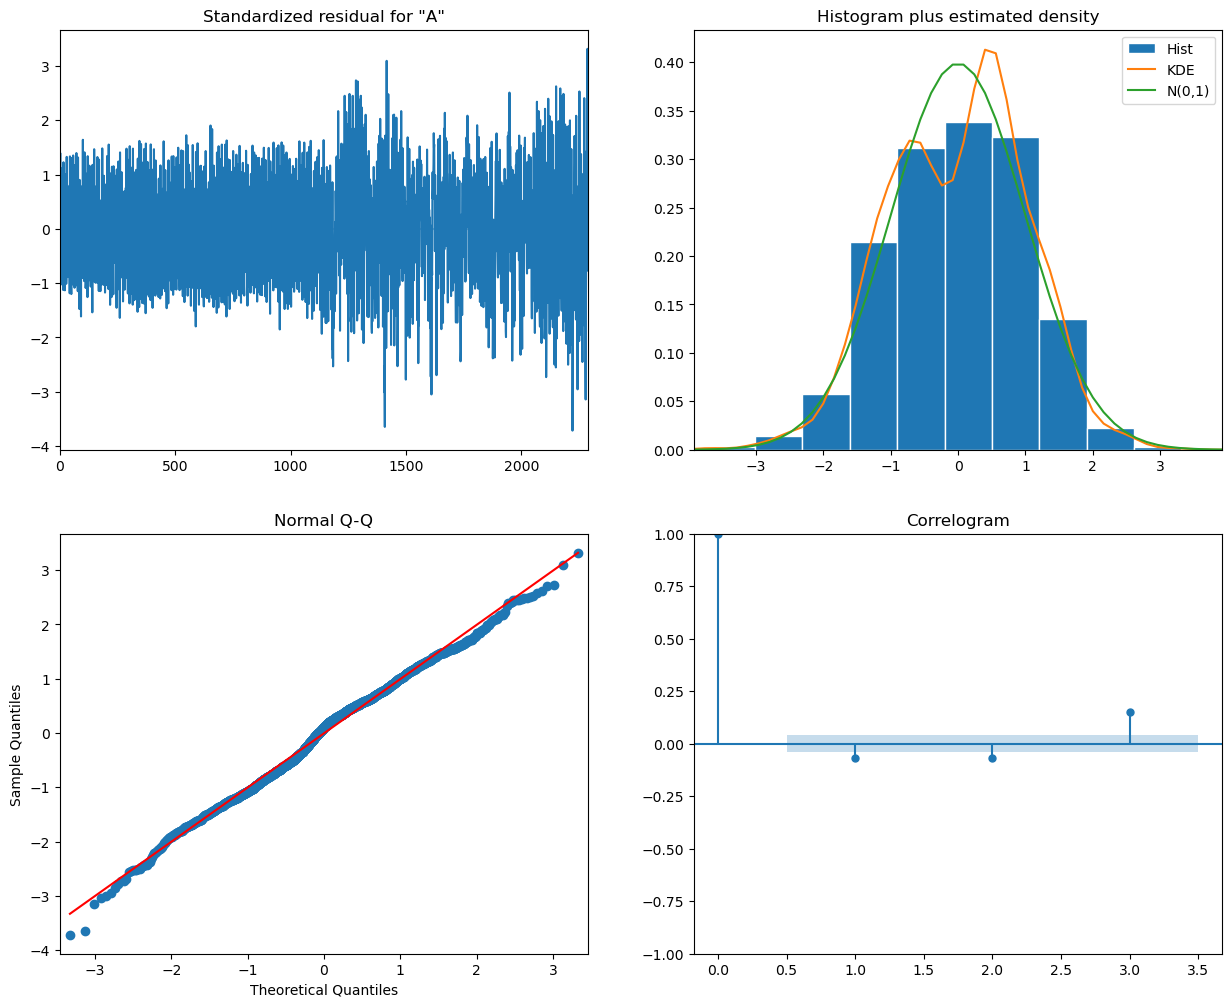

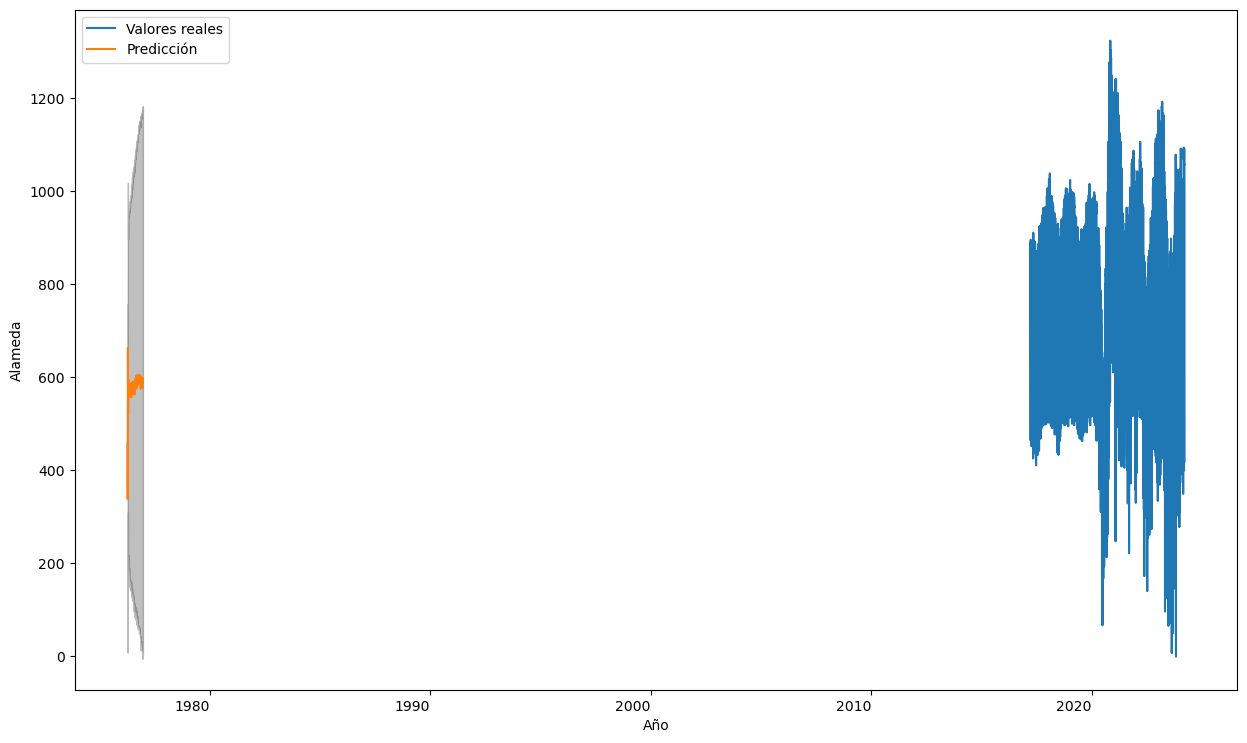

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Cargar los datos
Alameda_pred = pd.read_excel('predicciones_cabello_alameda.xlsx')
df_temp = pd.read_excel('maximos_minimos.xlsx')

# Convertir la fecha a datetime y establecer como índice
df_temp['Fecha'] = pd.to_datetime(df_temp['Fecha'], format='%Y-%m-%d')
df_temp.set_index('Fecha', inplace=True)

# Convertir temperaturas a float (manejar separadores decimales)
df_temp['Temp. Máxima'] = df_temp['Temp. Máxima'].astype(str).str.replace(',', '.').astype(float)
df_temp['Temp. Mínima'] = df_temp['Temp. Mínima'].astype(str).str.replace(',', '.').astype(float)

# Convertir la fecha en Alameda_pred a datetime y establecer como índice
Alameda_pred['Time'] = pd.to_datetime(Alameda_pred['Time'], format='%Y-%m-%d')
Alameda_pred.set_index('Time', inplace=True)

# Unir los dataframes basados en las fechas comunes
df_combined = Alameda_pred.join(df_temp, how='inner')
# Crear las variables exógenas (temperaturas)
exog = df_combined[['Temp. Máxima', 'Temp. Mínima']]

# Verificar valores faltantes
print(df_combined.isnull().sum())

# Llenar o eliminar valores faltantes
df_combined.dropna(inplace=True)

# Actualizar variables exógenas después de eliminar valores faltantes
exog = df_combined[['Temp. Máxima', 'Temp. Mínima']]

# Dividir los datos en entrenamiento y prueba
serie_a_predecir = df_combined["Alameda_predicho"]
y_index = serie_a_predecir.index

date_train = int(len(y_index) * 0.9)
y_train = serie_a_predecir[y_index[:date_train]]
y_test = serie_a_predecir[y_index[date_train:]]

exog_train = exog.iloc[:date_train]
exog_test = exog.iloc[date_train:]

# Definir los posibles parámetros para el grid search
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(0, 0, 0, 0)]

# Buscar los mejores parámetros
best_score = float("inf")
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            exog=exog_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print(f'ARIMA{param}x{param_seasonal} - AIC:{results.aic}')
            if results.aic < best_score:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
        except:
            continue

print(f"El mejor modelo es ARIMA{best_params}x{best_seasonal_params} con un AIC de {best_score}")

# Entrenar el modelo con los mejores parámetros
mod = sm.tsa.statespace.SARIMAX(y_train,
                                exog=exog_train,
                                order=best_params,
                                seasonal_order=best_seasonal_params,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

# Resumen del modelo
print(results.summary().tables[1])

# Diagnósticos del modelo
results.plot_diagnostics(figsize=(15, 12), lags=2)
plt.show()

# Predicciones
pred_uc = results.get_forecast(steps=len(y_test), exog=exog_test)
pred_ci = pred_uc.conf_int()

ax = serie_a_predecir.plot(label='Valores reales', figsize=(15, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Predicción')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Año')
ax.set_ylabel('Alameda')

plt.legend()
plt.show()




In [6]:
print(y_train)

2017-03-21    862.012475
2017-03-22    799.513999
2017-03-23    831.313165
2017-03-24    800.960075
2017-03-25    594.288990
                 ...    
2023-07-02    183.253178
2023-07-03    760.435070
2023-07-04    801.098170
2023-07-05    804.222349
2023-07-06    766.077405
Name: Alameda_predicho, Length: 2294, dtype: float64


In [19]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Paso 1: Cargar los datos
Alameda_pred = pd.read_excel('predicciones_cabello_alameda.xlsx')
df_temp = pd.read_excel('maximos_minimos.xlsx')

# Paso 2: Preparar los datos
Alameda_pred.set_index("Time", inplace=True)
Alameda_pred = Alameda_pred.drop('Cabello_predicho', axis=1)

# Paso 3: Combinar los datos
# Suponiendo que `df_temp` también tiene una columna "Time" para combinar con `Alameda_pred`
df_temp.set_index("Time", inplace=True)
df_combined = Alameda_pred.join(df_temp, how='inner')

# Paso 4: Crear y ajustar el modelo ARIMA con regresores
# Asumimos que las temperaturas están en las columnas 'Temp_max' y 'Temp_min' en df_temp
# y la variable objetivo está en la columna 'Cabello_alameda'

# Separar la variable objetivo y los regresores
y = df_combined['Cabello_alameda']
X = df_combined[['Temp_max', 'Temp_min']]

# Crear el modelo ARIMA con regresores
model = ARIMA(endog=y, exog=X, order=(p, d, q))  # Reemplaza (p, d, q) por los parámetros del modelo ARIMA que prefieras

# Ajustar el modelo
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())




KeyError: "None of ['Time'] are in the columns"